In [23]:
from tqdm import tqdm

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

## New concepts introduced:
- $\pi_t(a) = \frac{e^{H_t(a)}}{\sum{e^{H_t}}}$
    - the probability of taking an action under preference function H
- Incremental updates and learning $Q_(n+1) = Q_n + 1/n[R_n - Q_n]$
    - The learning rate $\alpha = \frac{1}{n}$ determines the weight of the most recent error adjustment

# Efficiency and learning

In the introduction we covered the simple solution to the multi armed bandid problem. However, when it comes to training learning agents/algorithms we now consider memory and run time efficiency and we generalize the learning concept further

## Algorithm efficiency

In our initial implementation of the bandit algorithm we used a simple Action Value method where we calculate the sample averages to estimate the value of actions and epsilon greedy strategy to balance exploration and exploitation.

While solving the problem like this we calculated the action value pairs for each action again and again at each time step.  This take more time and memory because we need to store/append and process the history at each point in time as it grows.

- evaluate history of rewards at each point t
- growing memory requirement with t
- slower updates as history grows


## Incremental implementation

We can calculate the action value pairs incrementally if we use a more efficient formula:

$Q_(n+1) = Q_n + 1/n[R_n - Q_n]$

We derive this expression simply by writing out the original calculation in series notation and substituting Qn by removing the last term and adding the constant $\frac{(n-1)}{(n-1)}$ (this yields $Q_(n+1)$ as a function of Qn, via 1/(n-1) * $\sum{R}$

Okay so let's update the previous method to use fixed memory and time complexity:

Original method

In [1]:
from tqdm import tqdm

def flip_coin():    
    return np.random.uniform(0,1)

def flip_n(n=100,epsilon=0.5):
    return(np.mean([flip_coin() > epsilon for i in range(n)]))

def run_sim(game_len=500,n_bandits=10,epsilon = 0.1,scale = 0.3):
    
    time = range(1,game_len+1)
    
    #function to retun greedy action
    def greedy_action(R):
        '''
        return the best action given the average historical returns
        '''

        ave_R = [np.mean(band_vals) for band_vals in R.values()]
        return np.argmax(ave_R)
    
    def generate_mean(a=-1,b=1):
        return (b-a) * np.random.random_sample() + a
    
    def bandit(a,b):
        def inner(a=a,b=b):
            return np.random.normal(loc=a,scale=b)
        return inner
    
    means = [generate_mean() for i in range(n_bandits)]
    scale = scale
    bandits = [bandit(means[i],scale) for i in range(n_bandits)]
    optimal_strat = np.argmax(means)
    
    R = {}
    for y in range(k):
        R[y] = []

    #initialize list for returns
    R_all = []
    
    #initialize list for testing if we used optimal strat
    is_optimal = []
    
    for t in time:
        
        #we must try all machines at least once to exploit
        if t < k:
            action = t - 1
        #Explore or exploit?
        elif flip_coin() > epsilon:
            action = greedy_action(R) 
        else:
            action = np.random.choice(range(k))

        Rt = bandits[action]()
        R[action].append(Rt)
        R_all.append(Rt)
        is_optimal.append(action == optimal_strat)
        
    # plt.plot(time, R_all)
        
    return R, R_all, is_optimal
    
def bootstrap_sims(bootstraps=2000,game_len=500,n_bandits=10,epsilon = 0.1,scale = 0.3):
    time = range(1,game_len+1)
    sims = {i:[] for i in time}
    sim_optimal = {i:[] for i in time}
    
    for s in tqdm(range(bootstraps)):
        
        R, R_all, is_optimal = run_sim(game_len=game_len,n_bandits=n_bandits,epsilon=epsilon,scale=scale)

        for i,x in enumerate(R_all):
            sims[i+1].append(x)
            
        for i,x in enumerate(is_optimal):
            sim_optimal[i+1].append(x)
        
   
    R_average = [np.mean(x) for x in sims.values()] 
    optimal_average = [np.mean(x) for x in sim_optimal.values()] 
    results_df = pd.DataFrame(data={'time':time,'Reward_average':R_average,'optimal_average':optimal_average})
    results_df = results_df.set_index('time').stack().reset_index().rename(columns={'level_1':'var',0:'value'})
    sns.lineplot(data=results_df,x='time',y='value',hue='var').set(title='Average Rewards and %optimal action over time')
    
    return R_average, sims, results_df

New method

- make the action-value function more general
- replace the formula for the action value to use incremental method

In [14]:
def action_value(action=None,value=None):
    '''
    function closure for returning or updating action value pairs
    '''
    
    values = {}
    updates = {}
    
    def inner(action=None,value=None):
        if(value):
            
            try:
                updates[action] = updates[action] + 1
            except:
                updates[action] = 1
                
            try:
                values[action] = values[action] + (1/updates[action])*(value - values[action])
            except:
                values[action] = value
            
            
            return
        
        return values[action]
    
    return inner

So here is a very generic implementation of an anction value function that will return the value of an action or update the action value if a value is provided.  
For simplicity we enclose the function for each game so that the function can remember which action have what values

In [31]:
from tqdm import tqdm

def flip_coin():    
    return np.random.uniform(0,1)

def flip_n(n=100,epsilon=0.5):
    return(np.mean([flip_coin() > epsilon for i in range(n)])) 

def run_sim(game_len=500,n_bandits=10,epsilon = 0.1,scale = 0.3):
    
    time = range(1,game_len+1)
    value_fn = action_value()
    
    #function to retun greedy action
    def greedy_action():
        '''
        return the best action given the average historical returns
        '''
        values = [value_fn(action) for action in range(n_bandits)]
        return np.argmax(values)
    
    def generate_mean(a=-1,b=1):
        return (b-a) * np.random.random_sample() + a
    
    def bandit(a,b):
        def inner(a=a,b=b):
            return np.random.normal(loc=a,scale=b)
        return inner
    
    means = [generate_mean() for i in range(n_bandits)]
    scale = scale
    bandits = [bandit(means[i],scale) for i in range(n_bandits)]
    optimal_strat = np.argmax(means)
    
    #initialize list for returns
    R_all = []
    
    #initialize list for testing if we used optimal strat
    is_optimal = []
    
    for t in time:
        
        #we must try all machines at least once to exploit [and populate our value_fn]
        if t <= n_bandits:
            action = t - 1
        #Explore or exploit?
        elif flip_coin() > epsilon:
            action = greedy_action() 
        else:
            action = np.random.choice(range(n_bandits))

        Rt = bandits[action]()
        value_fn(action,Rt)
        R_all.append(Rt)
        is_optimal.append(action == optimal_strat)
        
    # plt.plot(time, R_all)
        
    return R_all, is_optimal
    
def bootstrap_sims(bootstraps=2000,game_len=500,n_bandits=10,epsilon = 0.1,scale = 0.3):
    time = range(1,game_len+1)
    sims = {i:[] for i in time}
    sim_optimal = {i:[] for i in time}
    
    for s in tqdm(range(bootstraps)):
        
        R_all, is_optimal = run_sim(game_len=game_len,n_bandits=n_bandits,epsilon=epsilon,scale=scale)

        for i,x in enumerate(R_all):
            sims[i+1].append(x)
            
        for i,x in enumerate(is_optimal):
            sim_optimal[i+1].append(x)
        
   
    R_average = [np.mean(x) for x in sims.values()] 
    optimal_average = [np.mean(x) for x in sim_optimal.values()] 
    results_df = pd.DataFrame(data={'time':time,'Reward_average':R_average,'optimal_average':optimal_average})
    results_df = results_df.set_index('time').stack().reset_index().rename(columns={'level_1':'var',0:'value'})
    sns.lineplot(data=results_df,x='time',y='value',hue='var').set(title='Average Rewards and %optimal action over time')
    
    return R_average, sims, results_df

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 104.14it/s]


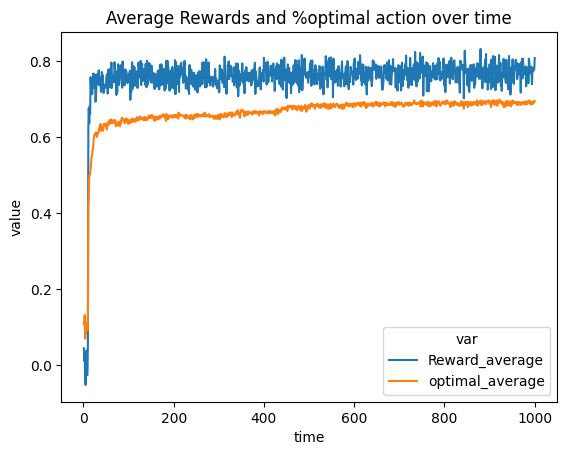

In [33]:
r, S, res_df = bootstrap_sims(bootstraps=500,game_len=1000,epsilon=0.01,scale=0.5)

Just from this example simulation we see that the new method runs at 104 iterations per second compared to before; 14 iterations per second...  
That's a increase in the processing speed of 

In [38]:
104/14

7.428571428571429

Note this improvement of roughly 7 fold was calculated while appending the results to the dataframe and then plotting them

## The learning rate and stationarity

In the above code we improved the learning algorithm by defining the action-value method update as follows;  
$Q_(n+1) = Q_n + 1/n[R_n - Q_n]$

Another way to write this in english is;  
NewEstimate = OldEstimate + StepSize [Target - OldEstimate]

In reinforcement learning the StepSize parameter is often called the `learning rate` $\alpha$.  

Here the learning rate is defined as $\frac{1}{n}$, but more generally this parameter can be learned or set.  

From our intuition around the action-value update we can say the following things about the learning rate:  
- if the learning rate varies like 1/n, we have a sample average solution for a stationary problem (the system does not change)
- this also means 1/n puts equal emphasis on new observations vs old ones
- A fixed value for the learning rate $\alpha$ puts more emphasis on the latest observations (since you are always moving towards the latest information at a fixed rate)
- Fixed $\alpha$ is also called the `weighted sample average approach` and is more appropriate for systems that are `nonstationary`

Here is an implementation using a learning rate instead

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def run_experiment(game_len, n_bandits, epsilon, scale, n_runs, alpha):
    optimal_counts = np.zeros(game_len)
    rewards = np.zeros(game_len)

     
    for i in tqdm(range(n_runs)):
        q_true = np.random.normal(0, scale, size=n_bandits)
        optimal_bandit = np.argmax(q_true)
        q_estimates = np.zeros(n_bandits)
        n_plays = np.zeros(n_bandits)

        for j in range(game_len):
            if np.random.random() < epsilon:
                a = np.random.choice(n_bandits)
            else:
                a = np.argmax(q_estimates)

            if a == optimal_bandit:
                optimal_counts[j] += 1

            reward = np.random.normal(q_true[a], scale)
            rewards[j] += reward

            n_plays[a] += 1
            q_estimates[a] += alpha * (reward - q_estimates[a])

    rewards /= n_runs
    optimal_counts /= n_runs

    plt.subplot(2, 1, 1)
    plt.plot(rewards)
    plt.ylabel('Average reward')

    plt.subplot(2, 1, 2)
    plt.plot(optimal_counts)
    plt.ylabel('% Optimal action')
    plt.xlabel('Step')

    plt.show()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:06<00:00, 307.79it/s]


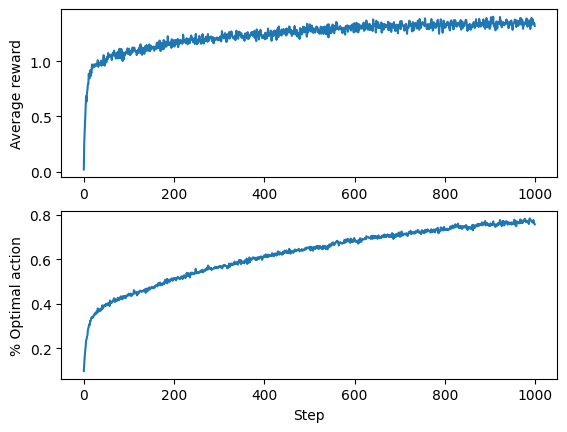

In [40]:
game_len = 1000
n_bandits = 10
epsilon = 0.1
scale = 1.0
n_runs = 2000
alpha = 0.1

run_experiment(game_len, n_bandits, epsilon, scale, n_runs, alpha)

## Initializing values

It's worth noting that in the case where $\alpha = \frac{1}{n}$ we are gaurenteed to converge to the true value for each action by the law of large numbers (sample average method).  

When we use a fixed value for $\alpha$ this is no longer true. Here we say that the final value estimates for each action is influenced by the initial values. 

The initial values are `irrelevant` for any problem that is `nonstationary`

So far we have decided to initialise the values for each bandit by using each machine at least once. Alternatively we can also initialize these values as 0 or we can use some domain expert to determine the priors

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def run_experiment(game_len, n_bandits, epsilon, scale, n_runs, alpha, initial):
    optimal_counts = np.zeros(game_len)
    rewards = np.zeros(game_len)

     
    for i in tqdm(range(n_runs)):
        q_true = np.random.normal(0, scale, size=n_bandits)
        optimal_bandit = np.argmax(q_true)
        q_estimates = np.array([initial]*n_bandits)
        n_plays = np.zeros(n_bandits)

        for j in range(game_len):
            if np.random.random() < epsilon:
                a = np.random.choice(n_bandits)
            else:
                a = np.argmax(q_estimates)

            if a == optimal_bandit:
                optimal_counts[j] += 1

            reward = np.random.normal(q_true[a], scale)
            rewards[j] += reward

            n_plays[a] += 1
            q_estimates[a] += alpha * (reward - q_estimates[a])

    rewards /= n_runs
    optimal_counts /= n_runs

    plt.subplot(2, 1, 1)
    plt.plot(rewards)
    plt.ylabel('Average reward')

    plt.subplot(2, 1, 2)
    plt.plot(optimal_counts)
    plt.ylabel('% Optimal action')
    plt.xlabel('Step')

    plt.show()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:06<00:00, 309.75it/s]


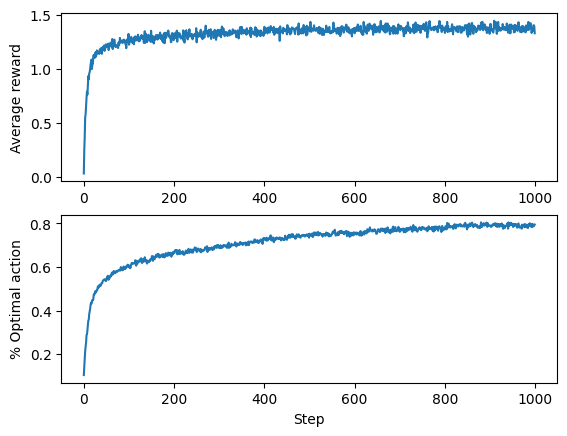

In [51]:
game_len = 1000
n_bandits = 10
epsilon = 0.1
scale = 1.0
n_runs = 2000
alpha = 0.1
initial = 0.5

run_experiment(game_len, n_bandits, epsilon, scale, n_runs, alpha, initial)

## Upper-Confidence-Bound action selection

Epsilon greedy action selection helps us balance exploration and exploitation by considering the best actions we currently know.  
However, we can be more clever in selecting which actions should be tried first in order to find the best bandit.

$a_t = \text{argmax}_a \left[ Q_t(a) + c \sqrt{\frac{\ln t}{N_t(a)}} \right]$


Where a_t is the best action at time t, Q_t(a) is the estimated value of action a at time t, N_t(a) is the number of times that action a has been selected up to time t, and c is a hyperparameter that controls the amount of exploration.

In [53]:
def run_experiment_ucb(game_len, n_bandits, c, scale, n_runs):
    optimal_counts = np.zeros(game_len)
    rewards = np.zeros(game_len)

    for i in tqdm(range(n_runs)):
        q_true = np.random.normal(0, scale, size=n_bandits)
        optimal_bandit = np.argmax(q_true)
        q_estimates = np.zeros(n_bandits)
        n_plays = np.zeros(n_bandits)

        for j in range(game_len):
            if np.sum(n_plays) < n_bandits:
                a = np.random.choice(n_bandits)
            else:
                a = np.argmax(q_estimates + c * np.sqrt(np.log(j+1)/(n_plays+1e-6)))

            if a == optimal_bandit:
                optimal_counts[j] += 1

            reward = np.random.normal(q_true[a], scale)
            rewards[j] += reward

            n_plays[a] += 1
            q_estimates[a] += (1/n_plays[a]) * (reward - q_estimates[a])

    rewards /= n_runs
    optimal_counts /= n_runs

    plt.subplot(2, 1, 1)
    plt.plot(rewards)
    plt.ylabel('Average reward')

    plt.subplot(2, 1, 2)
    plt.plot(optimal_counts)
    plt.ylabel('% Optimal action')
    plt.xlabel('Step')

    plt.show()



The UCB method for action selection involves balancing exploitation of the machine with the highest estimated value with exploration of machines with uncertain value estimates. The c parameter in the code controls the trade-off between these two objectives.

A larger value of C will incentivice more exploration

We added the value 1e-6 to the denominator when calculating the best action using the UCB method to avoid division by zero errors in cases where a particular action has not yet been selected. This is because the denominator is the number of times that each action has been selected, so if an action has not yet been selected, its denominator would be zero. By adding a small value such as 1e-6, we ensure that the denominator is never zero, which prevents division by zero errors.

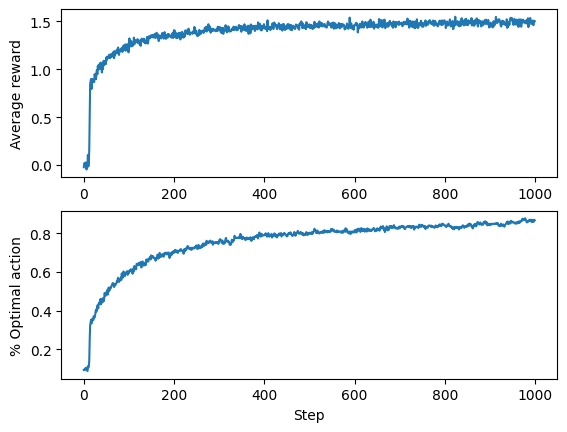

In [54]:
game_len = 1000
n_bandits = 10
c = 2
scale = 1.0
n_runs = 2000

run_experiment_ucb(game_len, n_bandits, c, scale, n_runs)



## Gradient Bandit Algorithms

Unlike the mothods before, the gradient bandit algorithm doesn't try to estimate action values but instead learns to prefer one choice over another. In other words this is an action preference model.  

Under this model we can numerically compare the preference of one action over another in a given state but we have no way of knowing the relative value or reward such an action could yield.


We generally denote this preference function as $H_t(a)$ and we can calculate the probability of taking an action as the softmax over all actions of $H_t(a)$ (denoted $\pi_t(a)$:

$\pi_t(a) = \frac{e^{H_t(a)}}{\sum{e^{H_t}}}$

which is euler's number raised to the preference of the action devided by the sum over the same expression for all actions

In [ ]:
import numpy as np

class GradientBandit:
    def __init__(self, n_bandits, alpha, baseline=False):
        self.n_bandits = n_bandits
        self.alpha = alpha
        self.baseline = baseline
        self.preferences = np.zeros(n_bandits)

        self.action_probs = np.ones(n_bandits) / n_bandits

        self.rewards = []
        self.actions = []

    def select_action(self):
        self.action_probs = np.exp(self.preferences) / np.sum(np.exp(self.preferences))
        return np.random.choice(self.n_bandits, p=self.action_probs)

    def update(self, action, reward):
        self.rewards.append(reward)
        self.actions.append(action)

        if self.baseline:
            baseline = np.mean(self.rewards)
        else:
            baseline = 0

        for i in range(self.n_bandits):
            if i == action:
                self.preferences[i] += self.alpha * (reward - baseline) * (1 - self.action_probs[i])
            else:
                self.preferences[i] -= self.alpha * (reward - baseline) * self.action_probs[i]



In [60]:
def run_experiment(game_len, n_bandits, alpha, n_runs, baseline=False):
    optimal_counts = np.zeros(game_len)
    rewards = np.zeros(game_len)

    for i in tqdm(range(n_runs)):
        q_true = np.random.normal(0, scale, size=n_bandits)
        optimal_bandit = np.argmax(q_true)

        bandit = GradientBandit(n_bandits, alpha, baseline)

        for j in range(game_len):
            action = bandit.select_action()

            if action == optimal_bandit:
                optimal_counts[j] += 1

            reward = np.random.normal(q_true[action], scale)
            rewards[j] += reward

            bandit.update(action, reward)

    rewards /= n_runs
    optimal_counts /= n_runs

    plt.subplot(2, 1, 1)
    plt.plot(rewards)
    plt.ylabel('Average reward')

    plt.subplot(2, 1, 2)
    plt.plot(optimal_counts)
    plt.ylabel('% Optimal action')
    plt.xlabel('Step')

    plt.show()


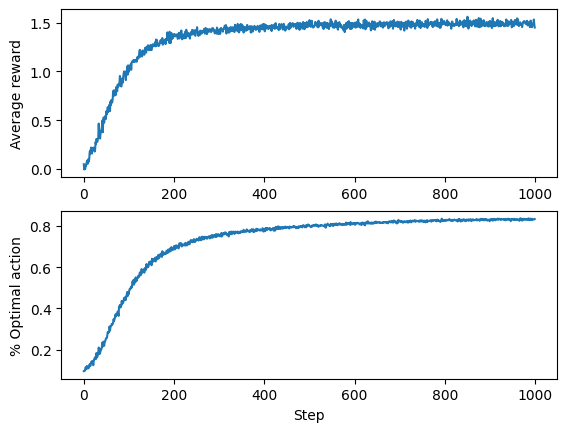

In [62]:
game_len = 1000
n_bandits = 10
alpha = 0.1
n_runs = 2000
baseline = False

run_experiment(game_len, n_bandits, alpha, n_runs, baseline)